# 1. Introduction 
In this notebook, we will perform simple binary image classification using PyTorch. For the Dataset, we will use pizza or not pizza dataset image from kaggle.com<br>
First we need download the dataset

In [ ]:
import pandas as pd
!pip install -q jcopdl gdown

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1eKzMqqmWcsazvVB9dDFnGTOkYzQnvNWn/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1WF1FFhp4cMGv8iYWtX2QUpENnienmx5e
To: /content/pizza_not_pizza.zip
100% 105M/105M [00:02<00:00, 35.5MB/s] 


In [ ]:
!unzip -q -n /content/pizza_not_pizza.zip

we will use torchvision to do classification task

In [ ]:
import torch
from PIL import Image
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

because google colab has GPU hardware accelerator for instance runtime, we will use it since it will speed up training model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = ImageFolder("/content/pizza_not_pizza")
trainData, testData, trainLabel, testLabel = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42, stratify=dataset.targets)
device

device(type='cuda')

In this task, we will use MobileNet v2 as based model for transfer learning

# 2. Dataset and ImageLoader

In [ ]:
bs = 32
crop_size = 224

transformer = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(0.3),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = self.checkChannel(dataset)
        self.transform = transform

    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if Image.open(dataset[index][0]).getbands() == ("R", "G", "B"):
                datasetRGB.append(dataset[index])
        return datasetRGB

    """def getResizedImage(self, item):
        image = Image.open(self.dataset[item][0])
        _, _ , width, height = image.getbbox()
        factor = (0,0,width,width) if width > height else (0,0,height,height)
        return image.crop(factor)"""

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        if self.transform is not None:
            return self.transform(image), self.dataset[item][1]
        return image, self.dataset[item][1]

    def __len__(self):
        return len(self.dataset)

train_set = ImageLoader(trainData, transformer["train"])
test_set = ImageLoader(testData, transformer["test"])

trainLoader = DataLoader(train_set, batch_size=bs, shuffle=True)
testLoader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [ ]:
dataset.classes

['not_pizza', 'pizza']

In [ ]:
from torchvision.models import mobilenet_v2
from torch import nn

In [ ]:
class CustomMobilenet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, 2),
            nn.LogSoftmax()
        )
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [ ]:
import torch
from jcopdl.callback import Callback, set_config

# 3. MCOC (Model, Criterion, Optimizers, and Callback) 

In [ ]:
set_config = config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

model = CustomMobilenet().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=3, outdir='model')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

# 4. Adaptation

Train:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4448 | Test_cost  = 0.3251 | Train_score = 0.8047 | Test_score = 0.8553 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.2864 | Test_cost  = 0.2995 | Train_score = 0.8836 | Test_score = 0.8731 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.2417 | Test_cost  = 0.2159 | Train_score = 0.9071 | Test_score = 0.9061 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2143 | Test_cost  = 0.2144 | Train_score = 0.9167 | Test_score = 0.9036 |
==> EarlyStop patience =  1 | Best test_score: 0.9061


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2034 | Test_cost  = 0.1957 | Train_score = 0.9224 | Test_score = 0.9162 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.2075 | Test_cost  = 0.1922 | Train_score = 0.9148 | Test_score = 0.9315 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2110 | Test_cost  = 0.1991 | Train_score = 0.9141 | Test_score = 0.9112 |
==> EarlyStop patience =  1 | Best test_score: 0.9315


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2161 | Test_cost  = 0.1905 | Train_score = 0.9116 | Test_score = 0.9162 |
==> EarlyStop patience =  2 | Best test_score: 0.9315


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1960 | Test_cost  = 0.1885 | Train_score = 0.9179 | Test_score = 0.9365 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1893 | Test_cost  = 0.2320 | Train_score = 0.9332 | Test_score = 0.9086 |
==> EarlyStop patience =  1 | Best test_score: 0.9365


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1885 | Test_cost  = 0.1988 | Train_score = 0.9281 | Test_score = 0.9239 |
==> EarlyStop patience =  2 | Best test_score: 0.9365


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1927 | Test_cost  = 0.1801 | Train_score = 0.9192 | Test_score = 0.9289 |
==> EarlyStop patience =  3 | Best test_score: 0.9365
==> Execute Early Stopping at epoch: 12 | Best test_score: 0.9365
==> Best model is saved at model


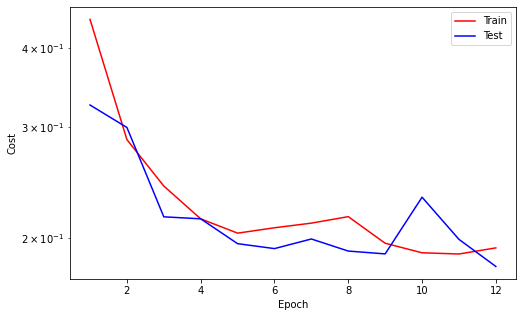

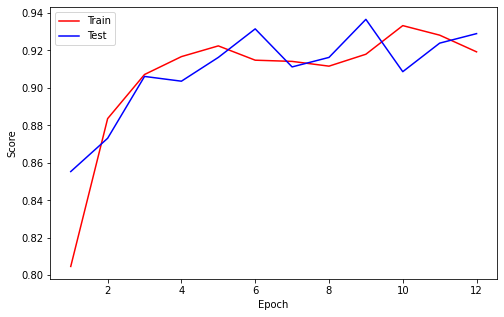

In [ ]:
def looping():
    while True:
        train_cost, train_score = loop_fn("train", train_set, trainLoader, model, criterion, optimizer, device)
        with torch.no_grad():
            test_cost, test_score = loop_fn("test", test_set, testLoader, model, criterion, optimizer, device)
        
        # Logging
        callback.log(train_cost, test_cost, train_score, test_score)

        # Checkpoint
        callback.save_checkpoint()
            
        # Runtime Plotting
        callback.cost_runtime_plotting()
        callback.score_runtime_plotting()
        
        # Early Stopping
        if callback.early_stopping(model, monitor="test_score"):
            callback.plot_cost()
            callback.plot_score()
            break
looping()

# 5. Fine Tuning

In [ ]:
model.unfreeze()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
callback = Callback(model, config, early_stop_patience=5, outdir='model')

Train:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.1650 | Test_cost  = 0.1914 | Train_score = 0.9402 | Test_score = 0.9188 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1711 | Test_cost  = 0.2150 | Train_score = 0.9345 | Test_score = 0.9112 |
==> EarlyStop patience =  1 | Best test_score: 0.9188


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1508 | Test_cost  = 0.1584 | Train_score = 0.9459 | Test_score = 0.9289 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1315 | Test_cost  = 0.1855 | Train_score = 0.9491 | Test_score = 0.9289 |
==> EarlyStop patience =  1 | Best test_score: 0.9289


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1288 | Test_cost  = 0.1734 | Train_score = 0.9536 | Test_score = 0.9315 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1353 | Test_cost  = 0.1805 | Train_score = 0.9491 | Test_score = 0.9315 |
==> EarlyStop patience =  1 | Best test_score: 0.9315


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1095 | Test_cost  = 0.1831 | Train_score = 0.9567 | Test_score = 0.9213 |
==> EarlyStop patience =  2 | Best test_score: 0.9315


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.0979 | Test_cost  = 0.1539 | Train_score = 0.9612 | Test_score = 0.9340 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1085 | Test_cost  = 0.1701 | Train_score = 0.9637 | Test_score = 0.9289 |
==> EarlyStop patience =  1 | Best test_score: 0.9340


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.0938 | Test_cost  = 0.1577 | Train_score = 0.9650 | Test_score = 0.9467 |


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.0770 | Test_cost  = 0.1665 | Train_score = 0.9758 | Test_score = 0.9365 |
==> EarlyStop patience =  1 | Best test_score: 0.9467


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.0990 | Test_cost  = 0.1807 | Train_score = 0.9669 | Test_score = 0.9264 |
==> EarlyStop patience =  2 | Best test_score: 0.9467


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.0710 | Test_cost  = 0.1801 | Train_score = 0.9777 | Test_score = 0.9289 |
==> EarlyStop patience =  3 | Best test_score: 0.9467


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.0879 | Test_cost  = 0.1698 | Train_score = 0.9656 | Test_score = 0.9289 |
==> EarlyStop patience =  4 | Best test_score: 0.9467


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Test:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.0759 | Test_cost  = 0.1422 | Train_score = 0.9739 | Test_score = 0.9416 |
==> EarlyStop patience =  5 | Best test_score: 0.9467
==> Execute Early Stopping at epoch: 15 | Best test_score: 0.9467
==> Best model is saved at model


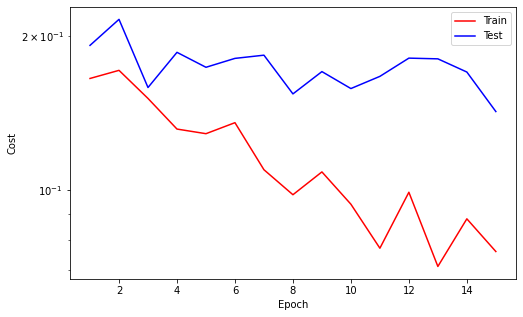

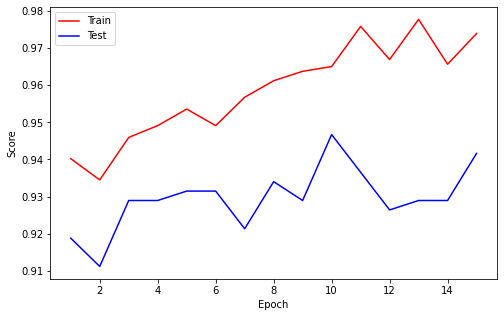

In [ ]:
looping()

In [ ]:
feature, target = next(iter(testLoader))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')

# 6. Sanity Check

In [ ]:
def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485    
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

In [ ]:
label2cat = dataset.classes

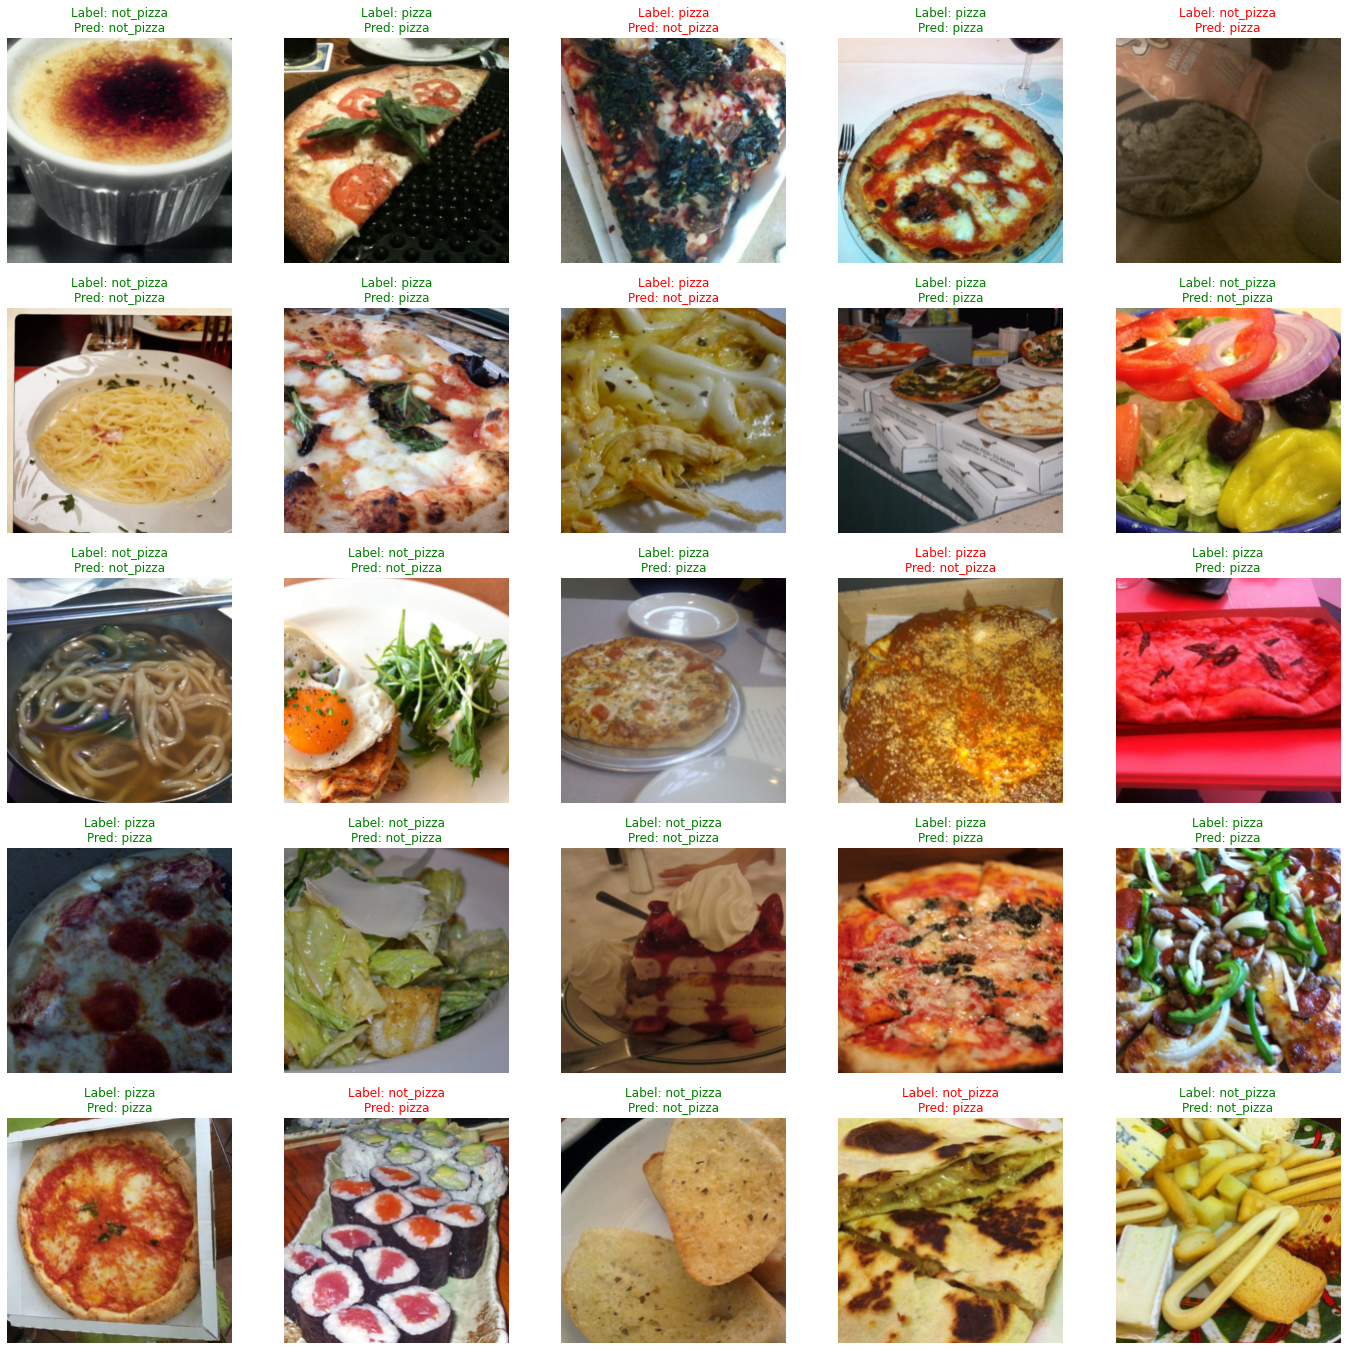

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(24,24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {"color": "r"} if (pred != label).any() else {"color": "g"}
    label, pred = label2cat[label], label2cat[pred]
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font)
    ax.axis('off')